In [4]:
import itertools
import time
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

%matplotlib inline
plt.style.use('ggplot')

In [5]:
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Times New Roman"

In [6]:
credit = pd.read_csv('/content/drive/MyDrive/comm_med_gfr/kidney_transplantation_work_pipeline_17_05_2023/Multilinear_Regression_new_021024/dat_red_new.csv', usecols=list(range(0,17)))
credit

,age_attx,sex,do_age,do_sex,do_type2,CIT,INF,hla_mm_a,hla_mm_b,hla_mm_d,pre_ab2,bloodt_4,preg2,no_tx2,gfr_in,speed,gfr_365
0,38.26,1,64.0,2,1,31.10,1,0,0,0,2,0,0,2,18.09,0.096995,23.460000
1,28.34,1,61.0,1,2,2.21,2,1,1,0,2,2,0,2,91.23,-0.197095,51.959522
2,62.24,2,62.0,1,1,17.34,1,0,1,1,2,0,2,2,25.10,0.247069,42.970000
3,24.01,1,53.0,1,2,2.44,2,1,1,1,2,1,0,2,81.34,-0.370439,45.903004
4,69.05,1,44.0,1,1,21.03,2,1,1,0,2,2,0,2,55.61,-0.138711,28.418852
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
349,43.63,2,69.0,2,2,2.58,2,0,1,1,2,1,2,2,27.86,-0.079948,18.482312
350,60.55,2,60.0,1,1,22.50,2,1,1,0,2,2,1,2,35.12,-0.071551,32.341746
351,50.41,1,60.0,1,1,17.75,1,1,1,1,2,2,0,2,55.23,-0.059673,58.586341
352,48.16,1,52.0,1,1,16.25,2,1,1,2,2,1,0,2,56.13,0.084348,39.361409


###**Best subset selection**

In [7]:
def fit_linear_reg(X,Y):
    #Fit linear regression model and return RSS and R squared values
    model_k = linear_model.LinearRegression(fit_intercept = True)
    model_k.fit(X,Y)
    RSS = mean_squared_error(Y,model_k.predict(X)) * len(Y)
    R_squared = model_k.score(X,Y)
    return RSS, R_squared

####**Forward stepwise selection**

In [8]:
#Initialization variables
Y = credit.gfr_365
X = credit.drop(columns = 'gfr_365', axis = 1)
k = 16

remaining_features = list(X.columns.values)
features = []
RSS_list, R_squared_list = [np.inf], [np.inf] #Due to 1 indexing of the loop...
features_list = dict()

for i in range(1,k+1):
    best_RSS = np.inf

    for combo in itertools.combinations(remaining_features,1):

            RSS = fit_linear_reg(X[list(combo) + features],Y)   #Store temp result

            if RSS[0] < best_RSS:
                best_RSS = RSS[0]
                best_R_squared = RSS[1]
                best_feature = combo[0]

    #Updating variables for next loop
    features.append(best_feature)
    remaining_features.remove(best_feature)

    #Saving values for plotting
    RSS_list.append(best_RSS)
    R_squared_list.append(best_R_squared)
    features_list[i] = features.copy()

In [9]:
print('Forward stepwise subset selection')
print('Number of features |', 'Features |', 'RSS')
display([(i,features_list[i], round(RSS_list[i])) for i in range(1,5)])

Forward stepwise subset selection
Number of features | Features | RSS


[(1, ['gfr_in'], 69104),
 (2, ['gfr_in', 'speed'], 57032),
 (3, ['gfr_in', 'speed', 'do_age'], 55277),
 (4, ['gfr_in', 'speed', 'do_age', 'bloodt_4'], 53749)]

###**Combining forward stepwise results into a new DataFrame**

In [10]:
df1 = pd.concat([pd.DataFrame({'features':features_list}),pd.DataFrame({'RSS':RSS_list, 'R_squared': R_squared_list})], axis=1, join='inner')
df1['numb_features'] = df1.index

In [11]:
#Initializing useful variables
m = len(Y)
p = 17
hat_sigma_squared = (1/(m - p -1)) * min(df1['RSS'])

#Computing
df1['C_p'] = (1/m) * (df1['RSS'] + 2 * df1['numb_features'] * hat_sigma_squared )
df1['AIC'] = (1/(m*hat_sigma_squared)) * (df1['RSS'] + 2 * df1['numb_features'] * hat_sigma_squared )
df1['BIC'] = (1/(m*hat_sigma_squared)) * (df1['RSS'] +  np.log(m) * df1['numb_features'] * hat_sigma_squared )
df1['R_squared_adj'] = 1 - ( (1 - df1['R_squared'])*(m-1)/(m-df1['numb_features'] -1))
df1

,features,RSS,R_squared,numb_features,C_p,AIC,BIC,R_squared_adj
1,[gfr_in],69104.259496,0.584887,1,196.092915,1.254464,1.265394,0.583707
2,"[gfr_in, speed]",57031.755660,0.657407,2,162.872938,1.041946,1.063806,0.655455
3,"[gfr_in, speed, do_age]",55277.379225,0.667946,3,158.800215,1.015891,1.048682,0.665099
4,"[gfr_in, speed, do_age, bloodt_4]",53748.996905,0.677127,4,155.365892,0.993921,1.037642,0.673426
5,"[gfr_in, speed, do_age, bloodt_4, do_type2]",53492.406869,0.678668,5,155.524204,0.994934,1.049585,0.674051
6,"[gfr_in, speed, do_age, bloodt_4, do_type2, INF]",53221.403893,0.680296,6,155.641800,0.995686,1.061267,0.674768
7,"[gfr_in, speed, do_age, bloodt_4, do_type2, IN...",53068.078770,0.681217,7,156.091820,0.998565,1.075077,0.674768
8,"[gfr_in, speed, do_age, bloodt_4, do_type2, IN...",52933.879655,0.682023,8,156.595869,1.001790,1.089231,0.674650
9,"[gfr_in, speed, do_age, bloodt_4, do_type2, IN...",52819.425588,0.682711,9,157.155694,1.005371,1.103743,0.674409
10,"[gfr_in, speed, do_age, bloodt_4, do_type2, IN...",52692.565027,0.683473,10,157.680473,1.008728,1.118030,0.674244


In [12]:
df1['R_squared_adj'].idxmax()
df1['R_squared_adj'].max()

0.6747678489383175

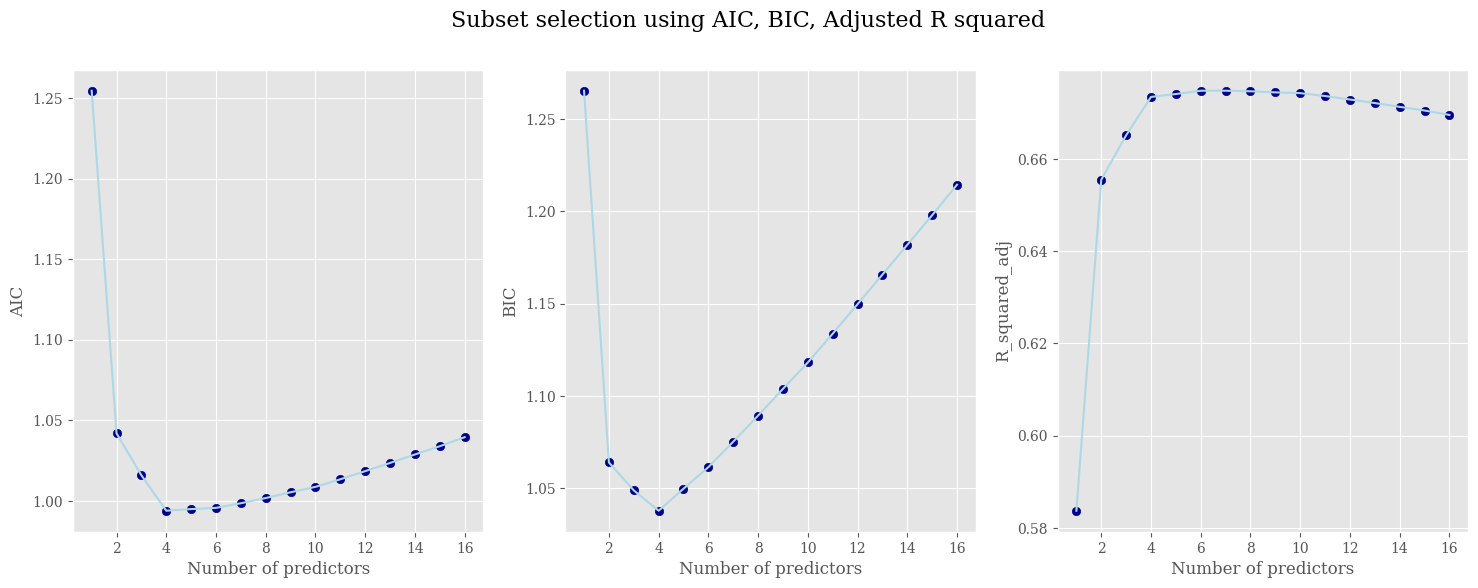

In [13]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

#variables = ['C_p', 'AIC','BIC','R_squared_adj']
variables = ['AIC','BIC','R_squared_adj']
fig = plt.figure(figsize = (18,6))

for i,v in enumerate(variables):
    ax = fig.add_subplot(1, 3, i+1)
    ax.plot(df1['numb_features'],df1[v], color = 'lightblue')
    ax.scatter(df1['numb_features'],df1[v], color = 'darkblue')
 #   if v == 'R_squared_adj':
 #       ax.plot(df1[v].idxmax(),df1[v].max(), marker = 'x', markersize = 20)
 #   else:
 #       ax.plot(df1[v].idxmin(),df1[v].min(), marker = 'x', markersize = 20)
    ax.set_xlabel('Number of predictors')
    ax.set_ylabel(v)

fig.suptitle('Subset selection using AIC, BIC, Adjusted R squared', fontsize = 16)
plt.show()